In [ ]:
#Goal of this notebook is to incorporate pymc3 modeling with a large dataset and predict pace.

In [1]:
#pip install pymc3

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.integrate import odeint
size = (12, 9)
from ipywidgets import interact, widgets, fixed
import json
import datetime as dt

In [3]:
import pymc3 as pm

In [4]:
import pandas as pd

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
raw_df = pd.read_csv('./data/clean/garmin_clean/clean_3.csv', index_col='date').drop('date.1', axis=1)

In [14]:
raw_df.head(2)

,activity_type,favorite,title,distance,calories,time,avg_hr,max_hr,aerobic_te,avg_run_cadence,...,decompression,best_lap_time,number_of_laps,max_temp,avg_resp,min_resp,max_resp,athlete_id,filetype,is_race
date,,,,,,,,,,,,,,,,,,,,,
2021-02-05 16:28:04,Running,False,Denver Running,8.27,945,01:02:23,151,170,3.5,178,...,No,01:02:22.97,1,0.0,26,14,43,3,garmin,0
2021-02-05 10:05:44,Indoor Cycling,False,Indoor Cycling,0.00,506,00:40:04,123,137,2.3,0,...,No,10:01.29,3,0.0,28,13,36,3,garmin,0


In [15]:
len(raw_df)

2340

In [16]:
running = raw_df[raw_df['activity_type'] == 'Running']

In [17]:
len(running)

668

In [22]:
running['distance'] = pd.to_numeric(running['distance'])

<ipython-input-22-a5fb980b449b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running['distance'] = pd.to_numeric(running['distance'])


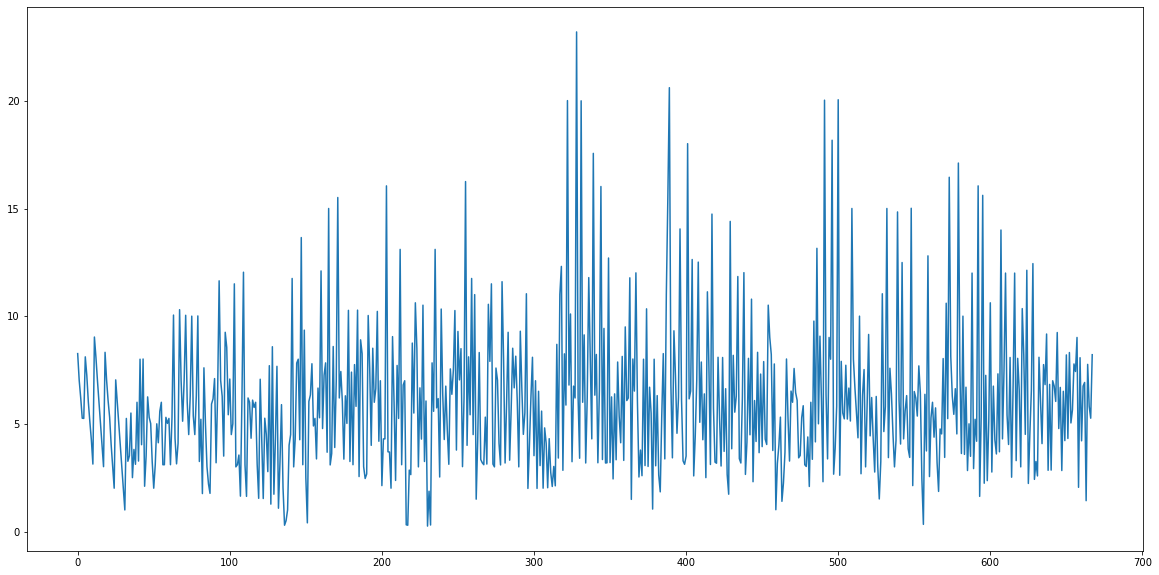

In [23]:
plt.figure(figsize = (20,10))
plt.plot(range(668), running['distance']);

In [30]:
#Read in the athlete dictionary:
with open("./data/athletes.json") as json_file: 
    athletes = json.load(json_file)

In [24]:
def analyze_file(filepath, sport, athlete_id): #Athlete id is a number no need to pass it the string:
    '''
    This function takes in a file, converts all the columns to numeric and date that we need,
    creates a speed column for running that converts pace to speed in ft/s, and prepares the 
    columns for the fit function that will later be used to predict the running pace. It will 
    create and output all the graphs we have here, for each of the races in the filepath.
    '''
    #Read in the dataframe:
    raw = pd.read_csv(filepath)
    sport = sport
    athlete_max_hr = athletes[str(athlete_id)]['max_hr']
    #Filter down just to the sport:
    df = raw[raw['activity_type'] == sport]
    
    
    #Setting average pace to a timedelta, we use a try in case the data does not have avg_pace column:
    try:
        df['avg_pace'] = pd.to_timedelta(df['avg_pace'])
    except:
        print("No avg_pace column!")
    
    try:
        df['distance'] = pd.to_numeric(df['distance'])
    except:
        print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    try:
        df['elev_gain'] = pd.to_numeric(df['elev_gain'].str.replace(',', ''))
    except:
        try:
            df['elev_gain'] = pd.to_numeric(df['elev_gain'])
        except:
            print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    #Create ft/mile column and intensity for analysis:
    df['ft_per_mile'] = (df['elev_gain']/df['distance'])
    df['intensity'] = df['avg_hr']/athlete_max_hr
    
    
    
    #Do the same for calculating speed in ft/s
    df['spd_ft_s'] = 0.0
    df['spd_mph'] = 0.0
    df.reset_index(inplace=True)
    
    for i in range(len(df['avg_pace'])):
        #.total_seconds returns the total seconds in a timedelta object.
        df['spd_mph'][i] = float(60/(df['avg_pace'][i].total_seconds()/60.0))
        #takes the speed in miles per hour and converts down to ft/s
        df['spd_ft_s'][i] = float(60.0/(df['avg_pace'][i].total_seconds()/60.0))*float(5280.0/3600.0)
        
    #The default is to be equal to the speed not taking into account elevation gain.
    df['GAP_ft_s'] = df['spd_ft_s']
    
    #Now we try to make a GAP column:
    for i in range(len(df)):
        #Try to make a GAP column:
        try:
            #using trig to calculate the change to the pace:
            factor = (np.sqrt((df['distance'][i]*5280)**2+df['elev_gain'][i]**2)/(df['distance'][i]*5280))
            df['GAP_ft_s'][i] = factor*df['spd_ft_s'][i]
        except:
            print("No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.")
        
    #Why divide by intensity? This brings average run pace up to the speed that we would expect if the athlete was at their highest average
    #sustainable heartrate for this speed. 
    df['GAP_by_intensity']  = df['GAP_ft_s']/df['intensity']
    
    #This creates a finalized dataframe with all of the columns I need for creating the pace curves.
    df.to_csv(filepath[:-4]+'_'+sport+'_extra_cols.csv')

In [25]:
filepath = './data/clean/garmin_clean/clean_3.csv'

In [31]:
analyze_file(filepath, 'Running', 3)

<ipython-input-24-00e626bde05f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_pace'] = pd.to_timedelta(df['avg_pace'])
<ipython-input-24-00e626bde05f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = pd.to_numeric(df['distance'])
<ipython-input-24-00e626bde05f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [33]:
#Still need to set the date column to datetime, and set the index with it:

In [34]:
running_df = pd.read_csv('./data/clean/garmin_clean/clean_3_Running_extra_cols.csv', index_col='date').drop('date.1', axis=1)

In [36]:
running_df.head(2)

,Unnamed: 0,index,activity_type,favorite,title,distance,calories,time,avg_hr,max_hr,...,max_resp,athlete_id,filetype,is_race,ft_per_mile,intensity,spd_ft_s,spd_mph,GAP_ft_s,GAP_by_intensity
date,,,,,,,,,,,,,,,,,,,,,
2021-02-05 16:28:04,0,0,Running,False,Denver Running,8.27,945,01:02:23,151,170,...,43,3,garmin,0,29.383313,0.843575,11.655629,7.947020,11.655810,13.817152
2021-02-04 15:38:04,1,2,Running,False,Denver Running,7.03,851,00:56:00,144,164,...,44,3,garmin,0,49.502134,0.804469,11.046025,7.531381,11.046511,13.731426


In [37]:
len(running_df)

668

In [44]:
running_df.index = pd.to_datetime(running_df.index).normalize()

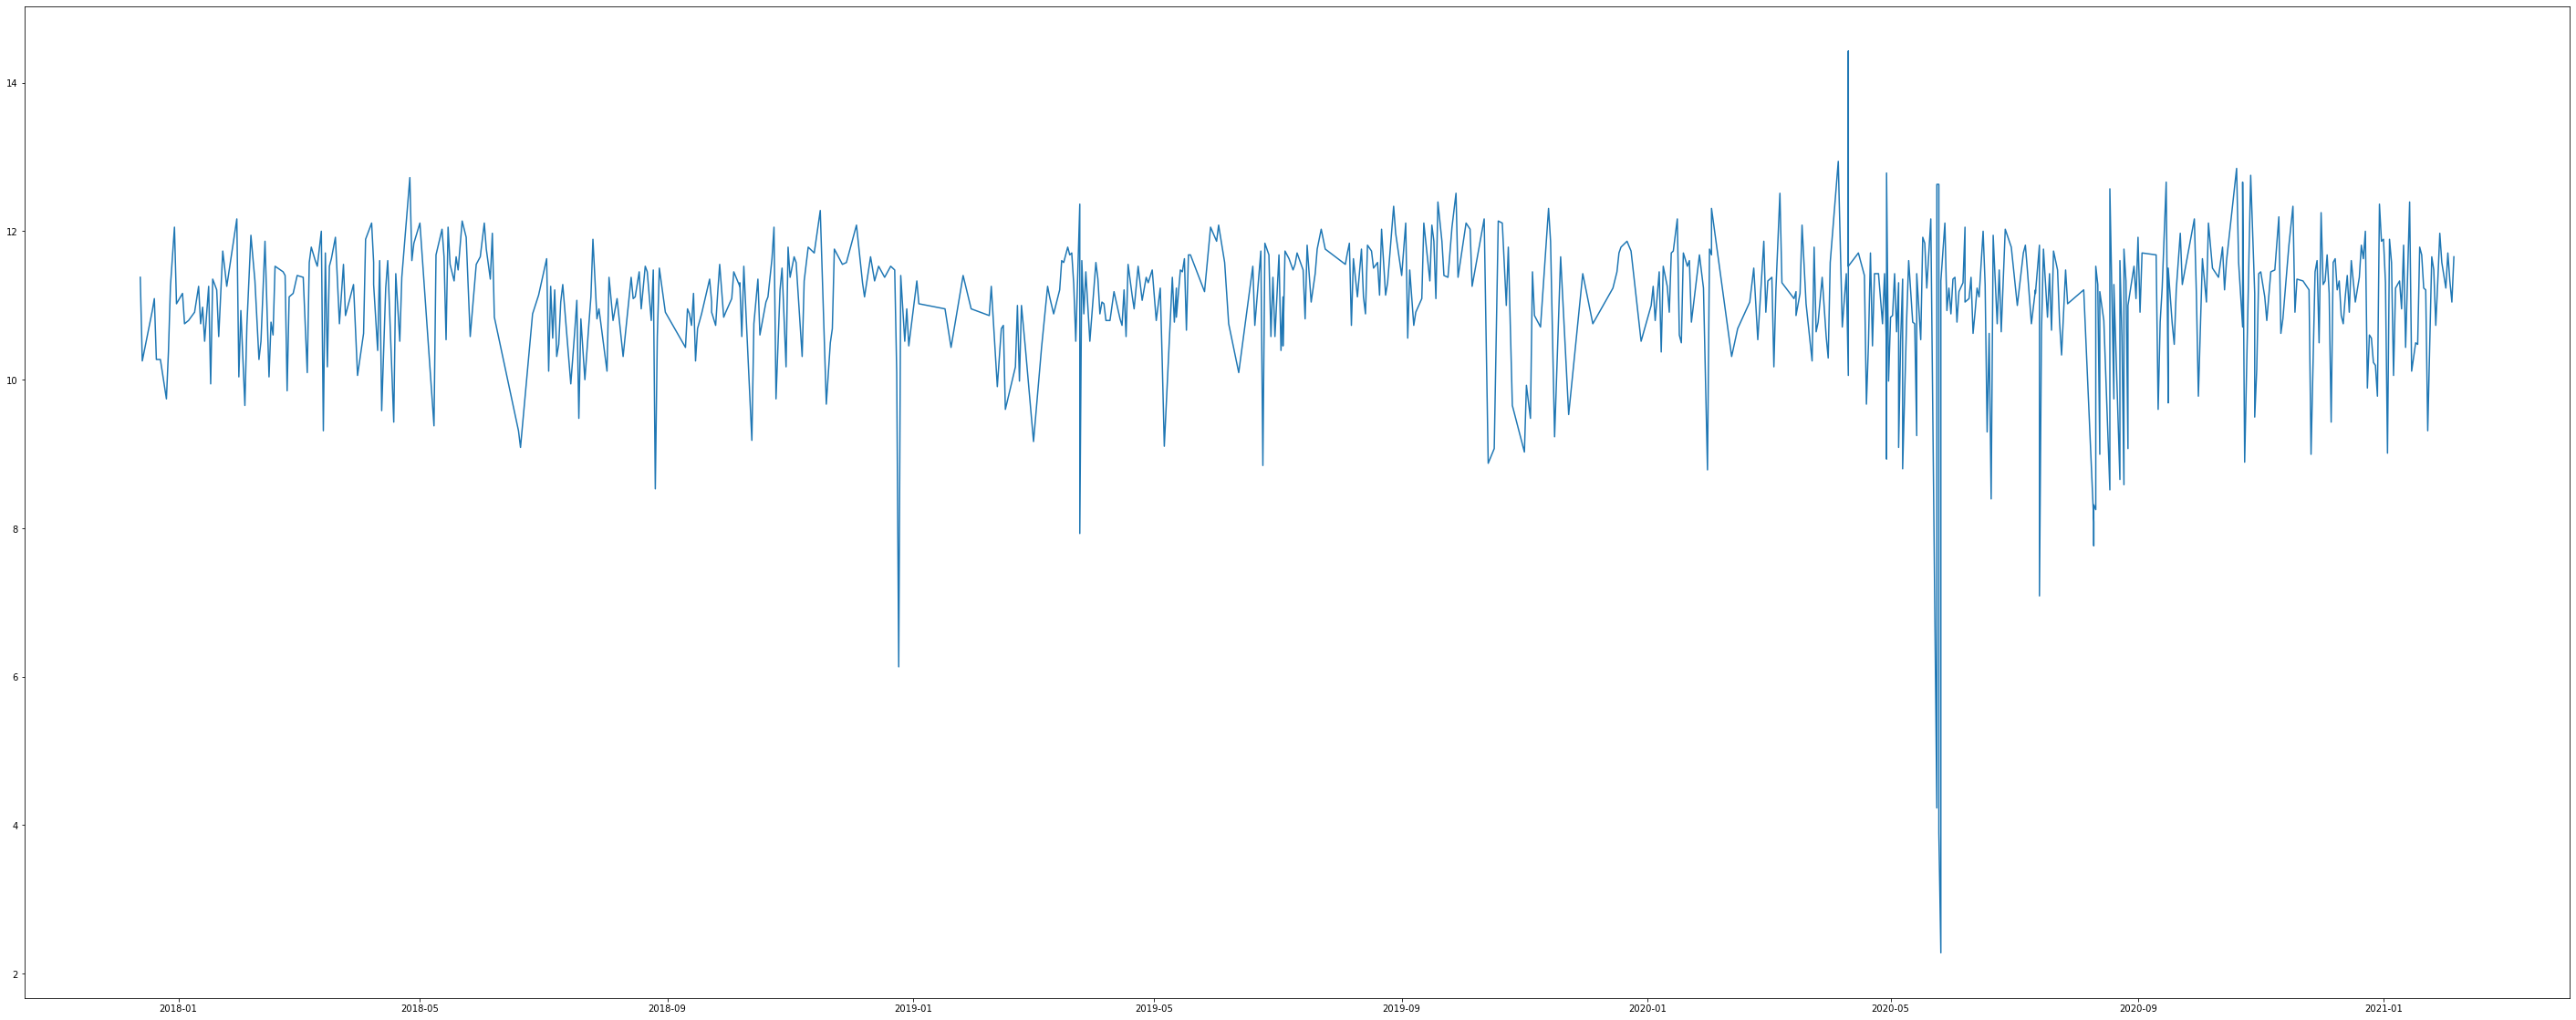

In [51]:
plt.figure(figsize = (50, 20))
plt.plot(running_df['spd_ft_s'])

In [52]:
running_df['spd_ft_s'].describe()

count    668.000000
mean      11.041532
std        0.993297
min        2.279793
25%       10.731707
50%       11.234043
75%       11.604396
max       14.426230
Name: spd_ft_s, dtype: float64

In [55]:
running_df.index.year

Int64Index([2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='date', length=668)

In [58]:
run_2019 = running_df[running_df.index.year == 2019]

Text(0.5, 1.0, 'Run Speed, 2019')

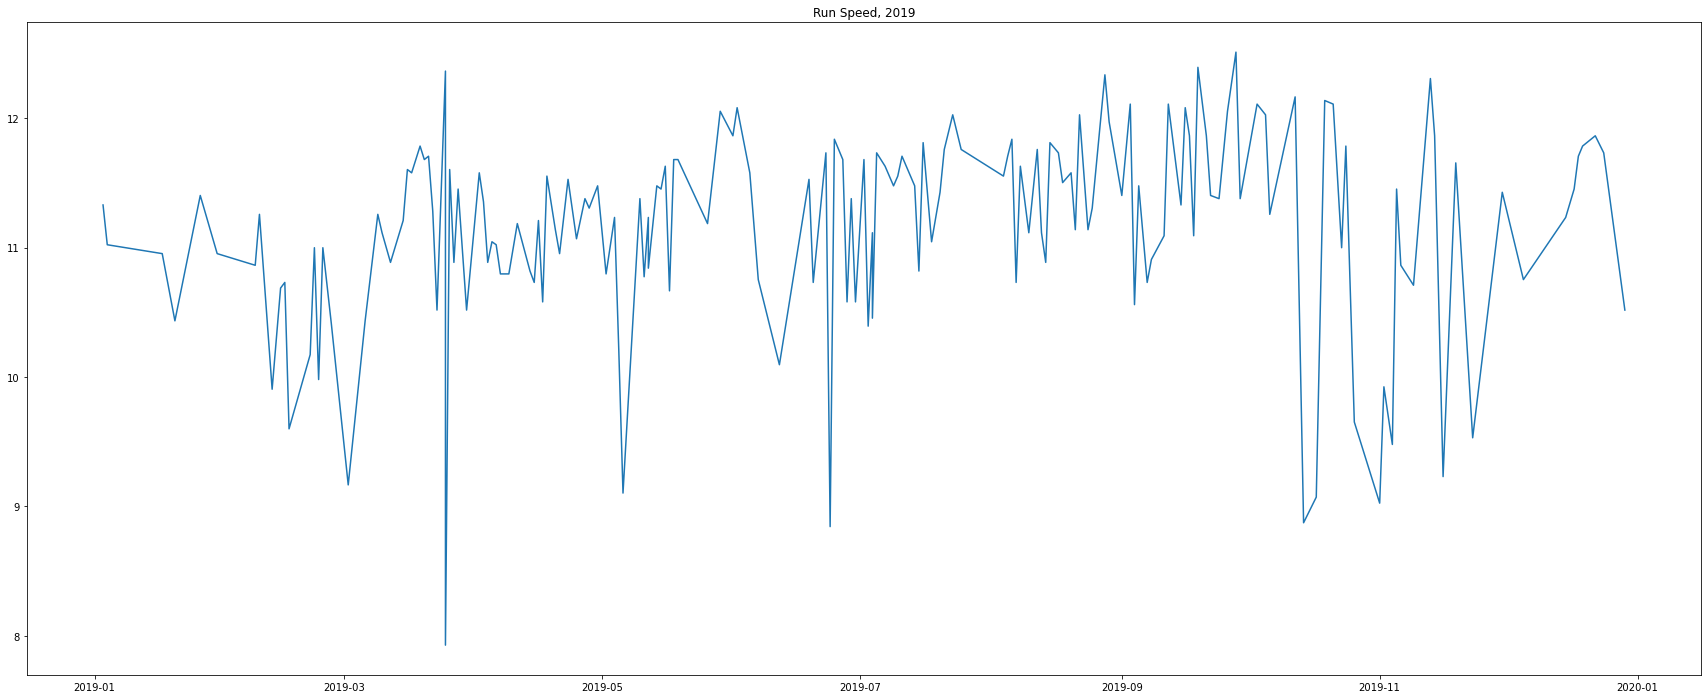

In [63]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['spd_ft_s'])
plt.title('Run Speed, 2019')

Text(0.5, 1.0, 'Run Speed/Intensity, 2019')

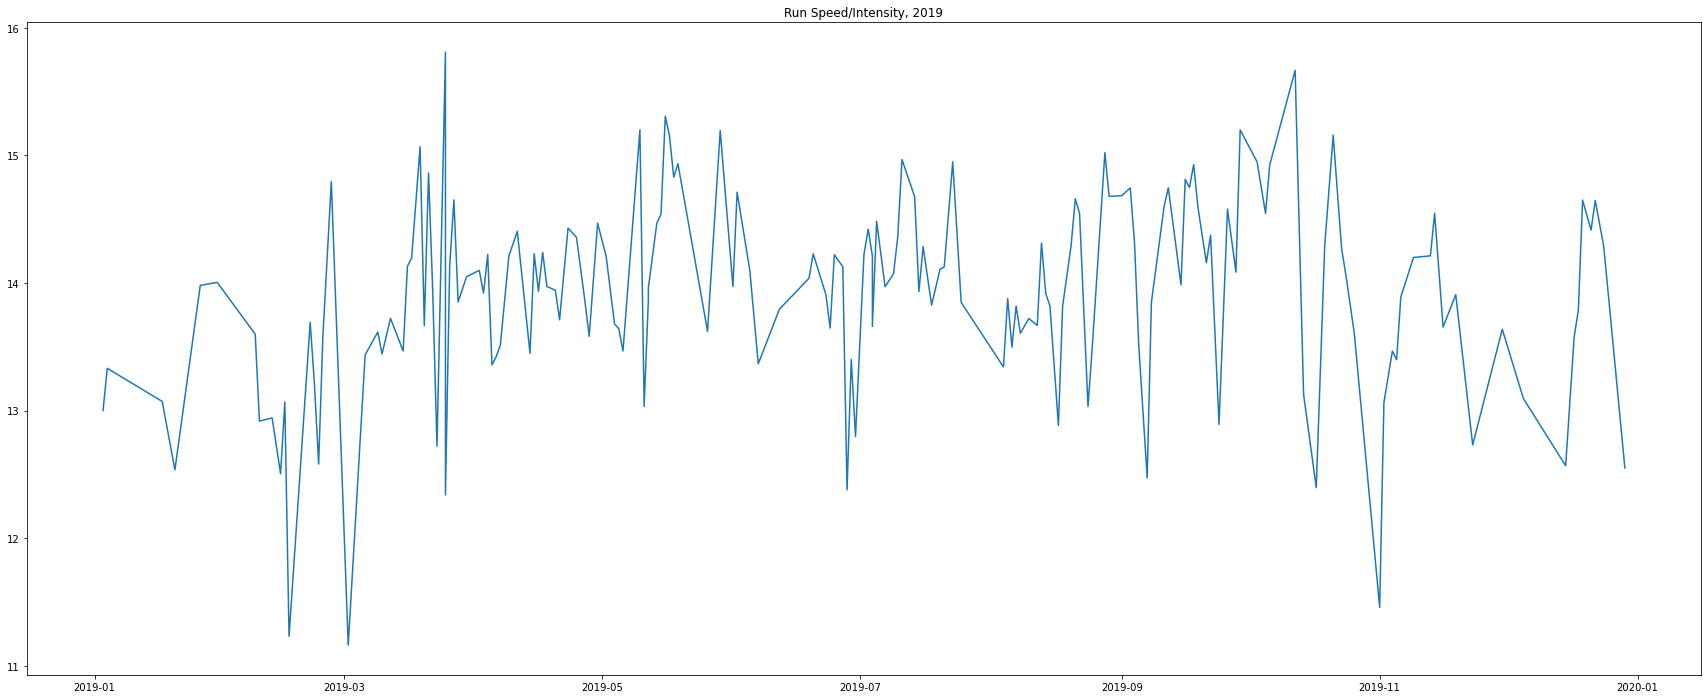

In [67]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['spd_ft_s']/(run_2019['intensity']))
plt.title('Run Speed/Intensity, 2019')

In [69]:
run_2019.columns

Index(['Unnamed: 0', 'index', 'activity_type', 'favorite', 'title', 'distance',
       'calories', 'time', 'avg_hr', 'max_hr', 'aerobic_te', 'avg_run_cadence',
       'max_run_cadence', 'avg_pace', 'best_pace', 'elev_gain', 'elev_loss',
       'avg_stride_length', 'avg_vertical_ratio', 'avg_vertical_oscillation',
       'avg_ground_contact_time', 'avg_gct_balance', 'avg_run_cadence_1',
       'max_run_cadence_1', 'normalized_powerâ_npâ', 'lr_balance',
       'training_stress_scoreâ', 'max_avg_power_20_min', 'avg_power',
       'max_power', 'grit', 'flow', 'total_strokes', 'avg__swolf',
       'avg_stroke_rate', 'total_reps', 'total_sets', 'climb_time',
       'bottom_time', 'min_temp', 'surface_interval', 'decompression',
       'best_lap_time', 'number_of_laps', 'max_temp', 'avg_resp', 'min_resp',
       'max_resp', 'athlete_id', 'filetype', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity'],
      dtype='object')

Text(0.5, 1.0, 'Run Speed/(Intensity*Distance), 2019')

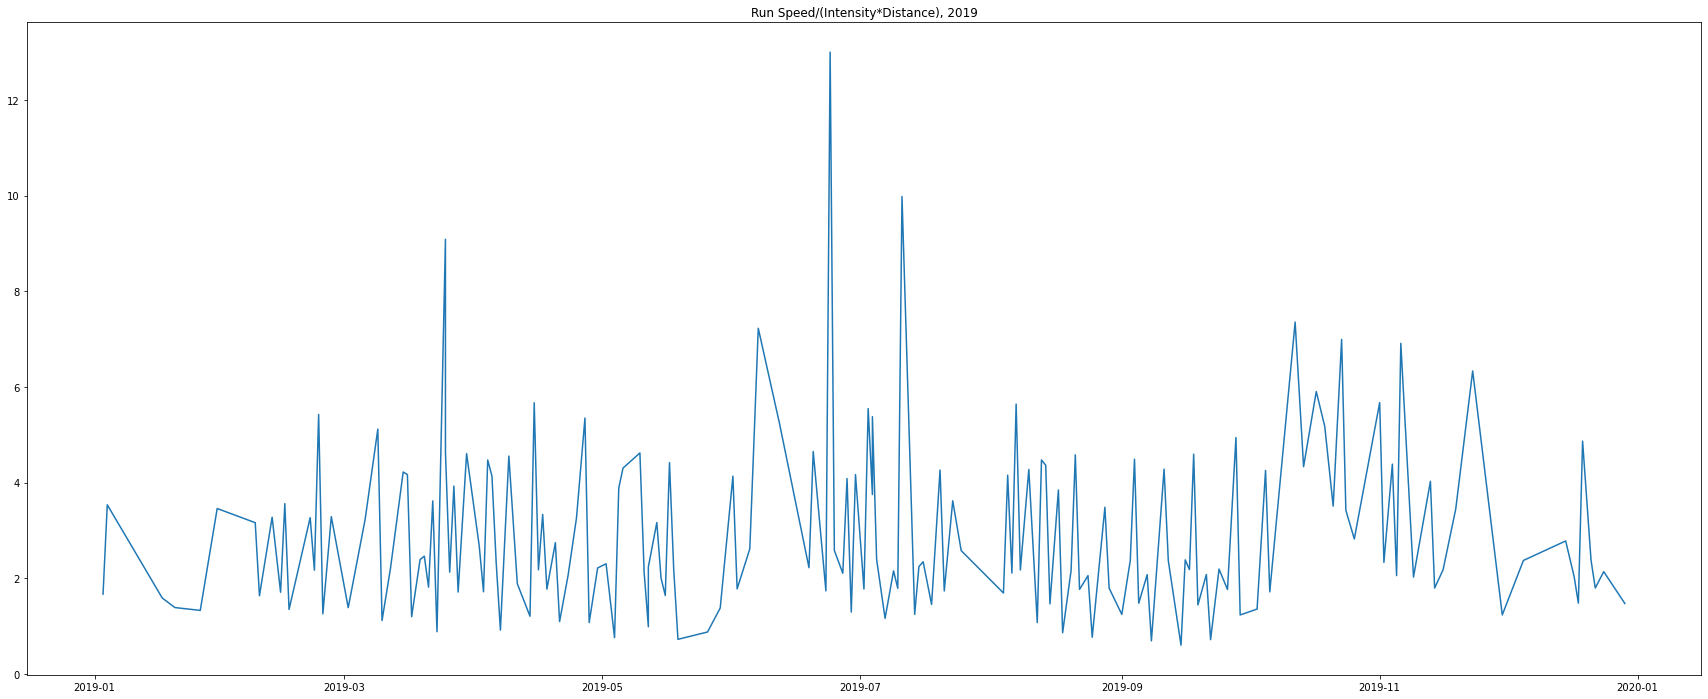

In [74]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['GAP_ft_s']/(run_2019['intensity']*run_2019['distance']))
plt.title('Run Speed/(Intensity*Distance), 2019')

Text(0.5, 1.0, 'Run Speed*Intensity*Distance, 2019')

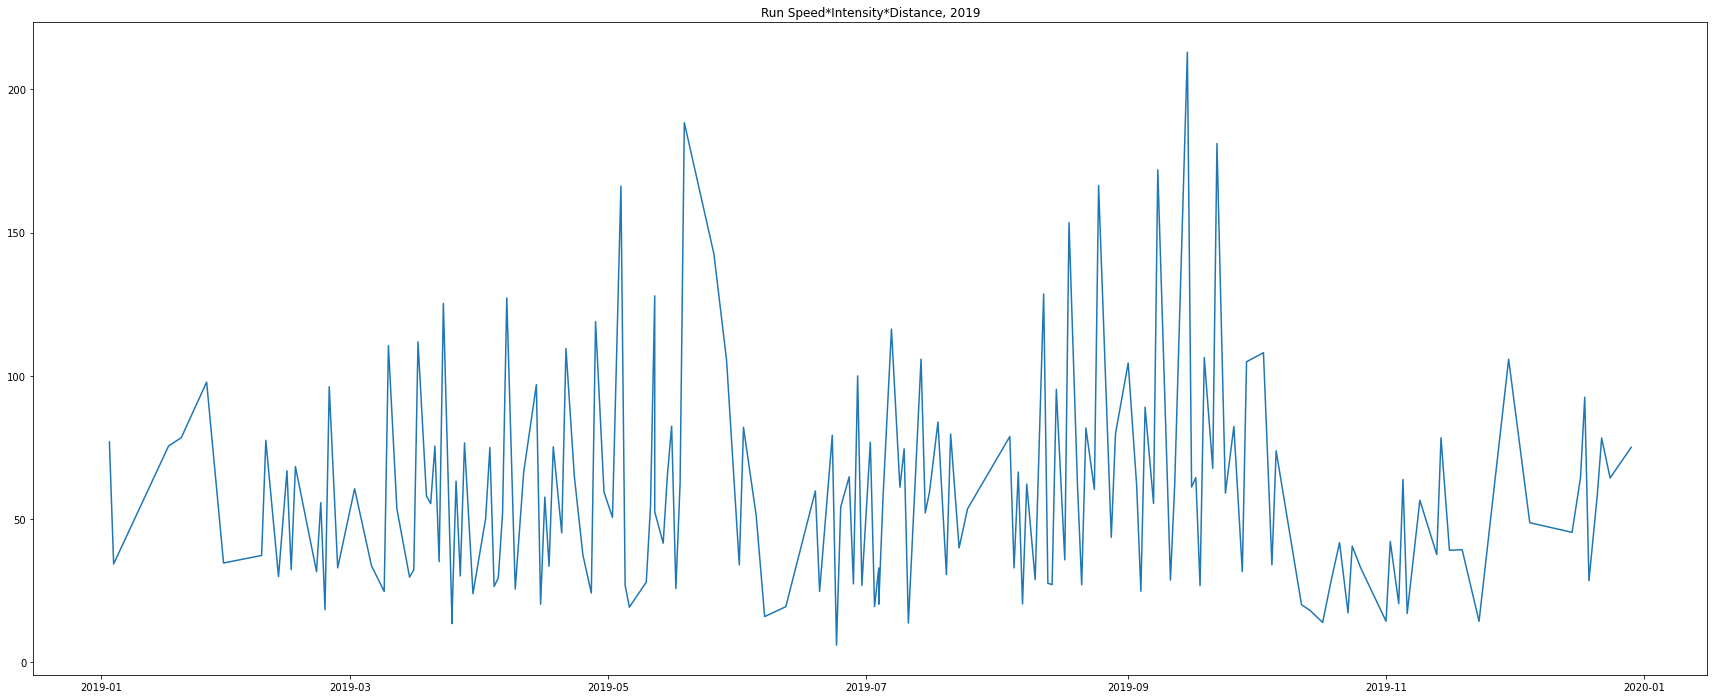

In [92]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['GAP_ft_s']*run_2019['distance']*run_2019['intensity'])
plt.title('Run Speed*Intensity*Distance, 2019')

In [80]:
run_2019['GAP_ft_s'].resample('W').mean()

date
2019-01-06    11.176965
2019-01-13          NaN
2019-01-20    10.695171
2019-01-27    11.403957
2019-02-03    10.955289
2019-02-10    11.061308
2019-02-17    10.232011
2019-02-24    10.538908
2019-03-03     9.790884
2019-03-10    10.936431
2019-03-17    11.320197
2019-03-24    11.394885
2019-03-31    10.792691
2019-04-07    11.114736
2019-04-14    10.934872
2019-04-21    11.028651
2019-04-28    11.320999
2019-05-05    10.930871
2019-05-12    10.667125
2019-05-19    11.432259
2019-05-26    11.186907
2019-06-02    12.000965
2019-06-09    11.166480
2019-06-16    10.095875
2019-06-23    11.331563
2019-06-30    10.817819
2019-07-07    11.168417
2019-07-14    11.554477
2019-07-21    11.373163
2019-07-28    11.893400
2019-08-04    11.553611
2019-08-11    11.404740
2019-08-18    11.468583
2019-08-25    11.438367
2019-09-01    11.904440
2019-09-08    11.158077
2019-09-15    11.511442
2019-09-22    11.784201
2019-09-29    11.831522
2019-10-06    11.798592
2019-10-13    12.166222
2019-10-20 

In [82]:
run_2019['distance'].resample('W').sum()

date
2019-01-06    11.56
2019-01-13     0.00
2019-01-20    17.26
2019-01-27    10.52
2019-02-03     4.05
2019-02-10    12.20
2019-02-17    23.27
2019-02-24    23.40
2019-03-03    12.55
2019-03-10    18.85
2019-03-17    24.64
2019-03-24    38.30
2019-03-31    25.91
2019-04-07    40.29
2019-04-14    21.90
2019-04-21    38.66
2019-04-28    26.65
2019-05-05    34.23
2019-05-12    32.84
2019-05-19    52.00
2019-05-26    15.52
2019-06-02    22.67
2019-06-09     7.24
2019-06-16     2.63
2019-06-23    17.39
2019-06-30    29.72
2019-07-07    35.01
2019-07-14    27.84
2019-07-21    33.26
2019-07-28     9.50
2019-08-04     7.88
2019-08-11    21.66
2019-08-18    47.92
2019-08-25    41.95
2019-09-01    24.29
2019-09-08    44.57
2019-09-15    32.85
2019-09-22    53.16
2019-09-29    29.31
2019-10-06    23.14
2019-10-13     2.13
2019-10-20     7.89
2019-10-27    15.29
2019-11-03     7.62
2019-11-10    18.61
2019-11-17    17.90
2019-11-24     6.04
2019-12-01    11.05
2019-12-08     5.52
2019-12-15     

Text(0.5, 1.0, 'Weekly Run Totals')

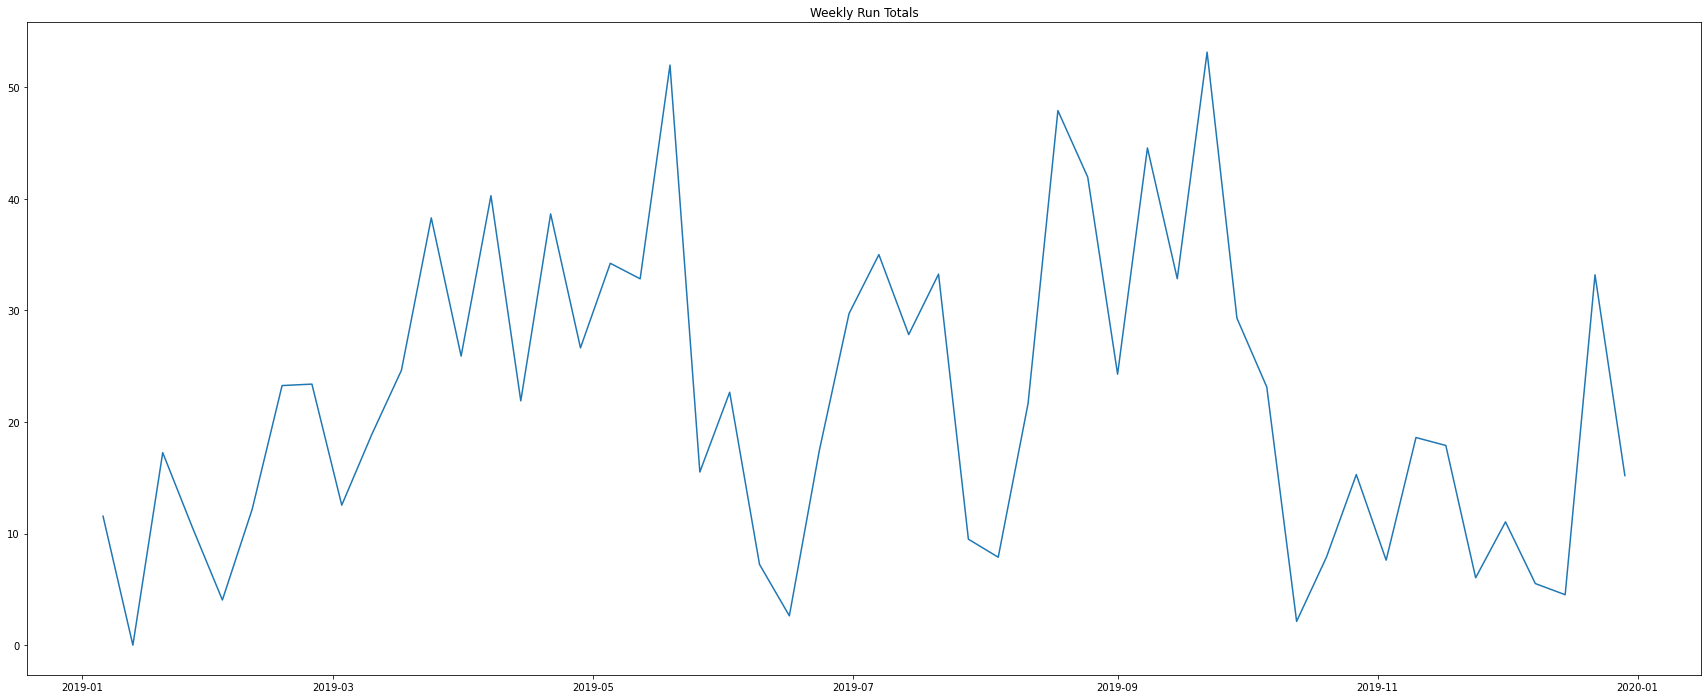

In [113]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['distance'].resample('W').sum())
plt.title('Weekly Run Totals')

Text(0.5, 1.0, 'Monthly Run Totals')

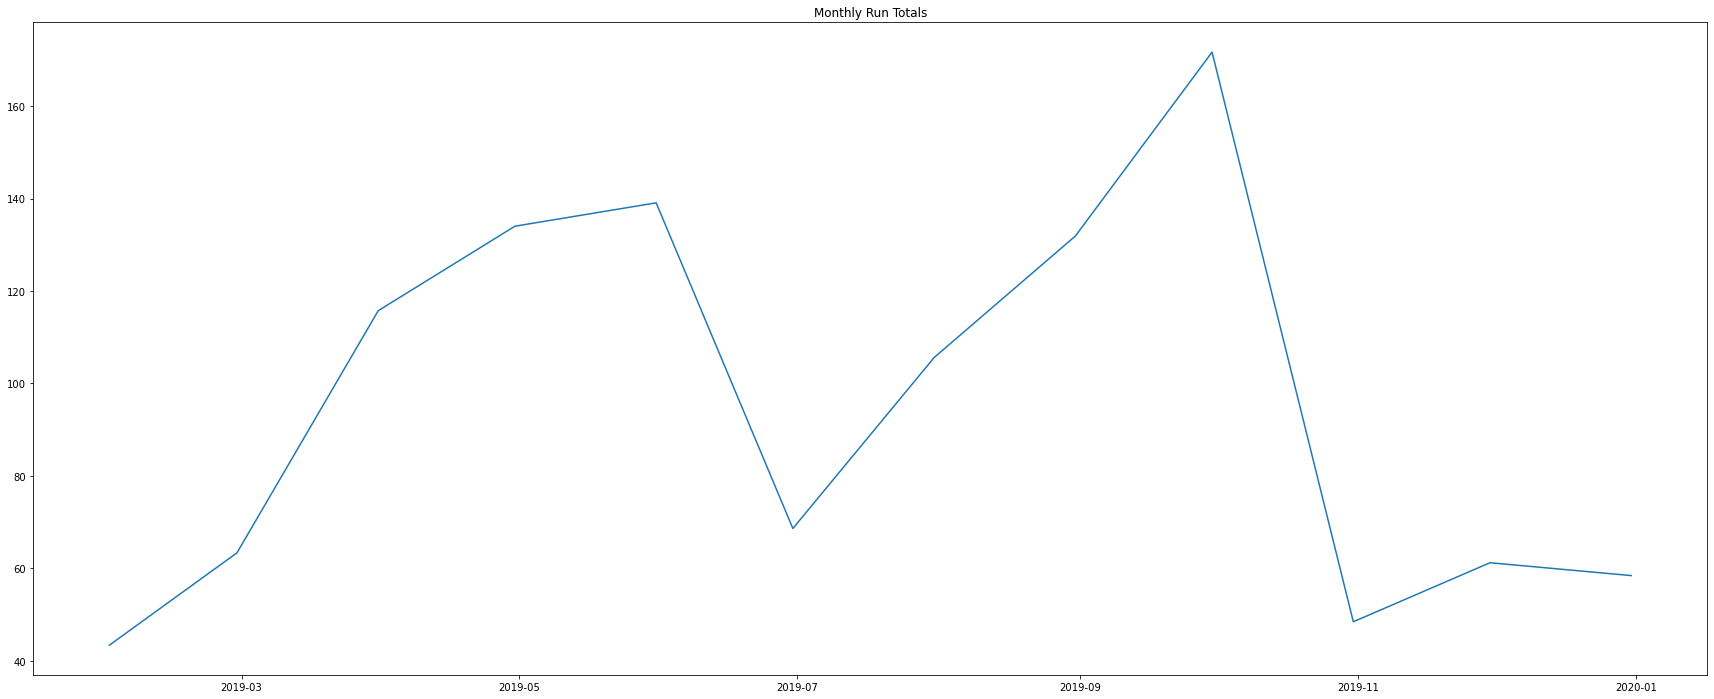

In [91]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['distance'].resample('M').sum())
plt.title('Monthly Run Totals')

## Lets look at 2018:

In [93]:
run_2018 = running_df[running_df.index.year == 2018]

Text(0.5, 1.0, 'Run Speed, 2018')

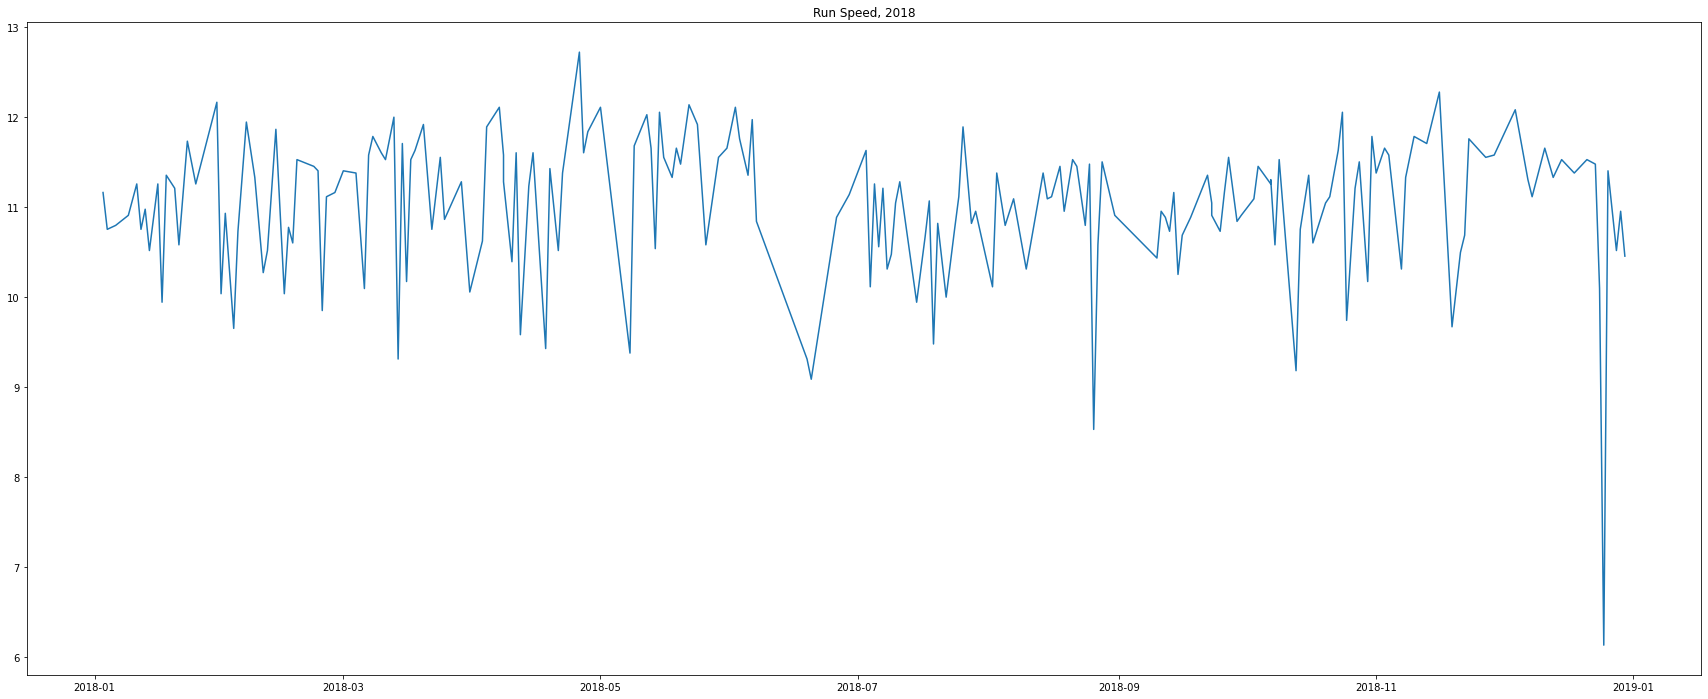

In [109]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['spd_ft_s'])
plt.title('Run Speed, 2018')

Text(0.5, 1.0, 'Run Speed/Intensity, 2018')

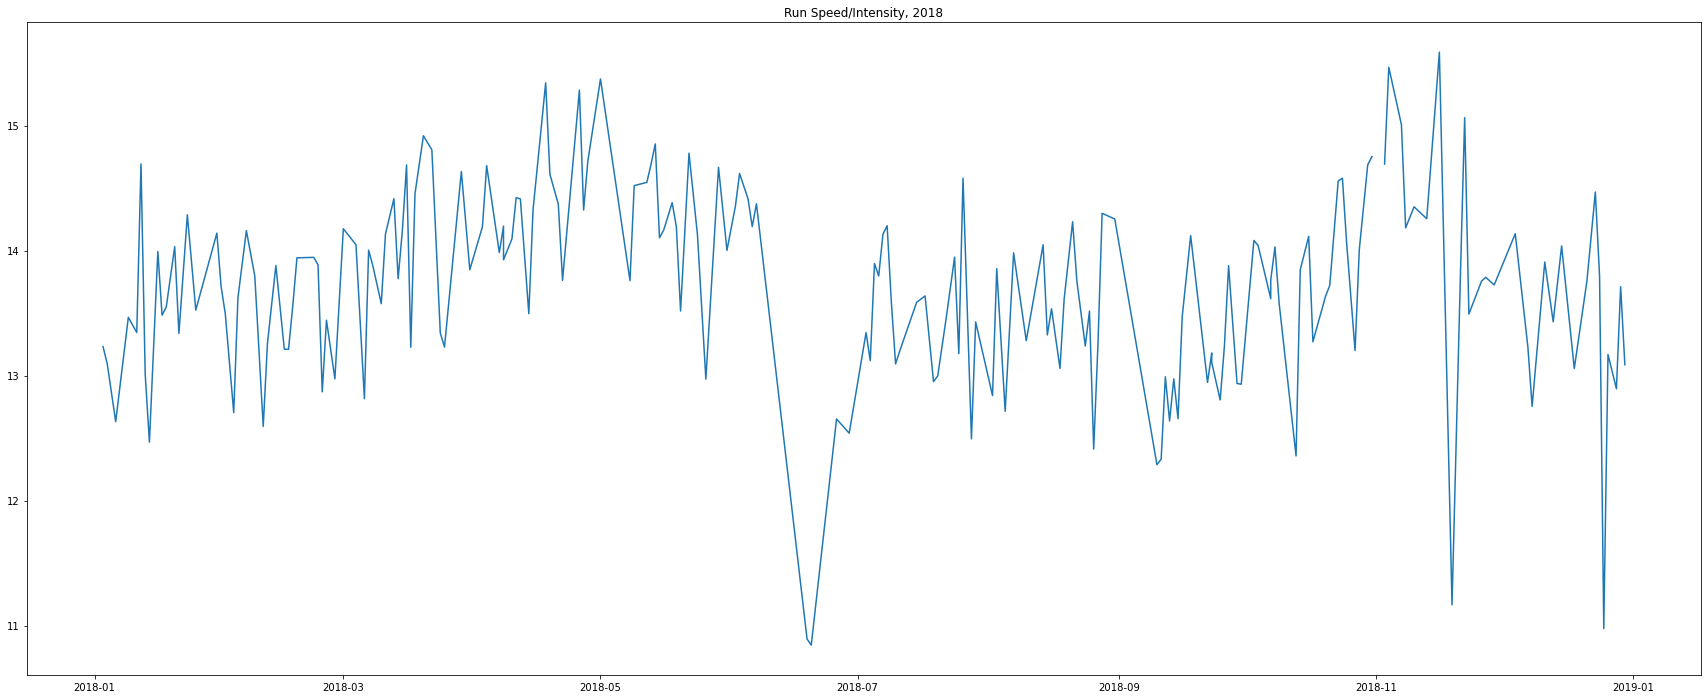

In [108]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['spd_ft_s']/(run_2018['intensity']))
plt.title('Run Speed/Intensity, 2018')

Text(0.5, 1.0, 'Run Speed/(Intensity*Distance), 2018')

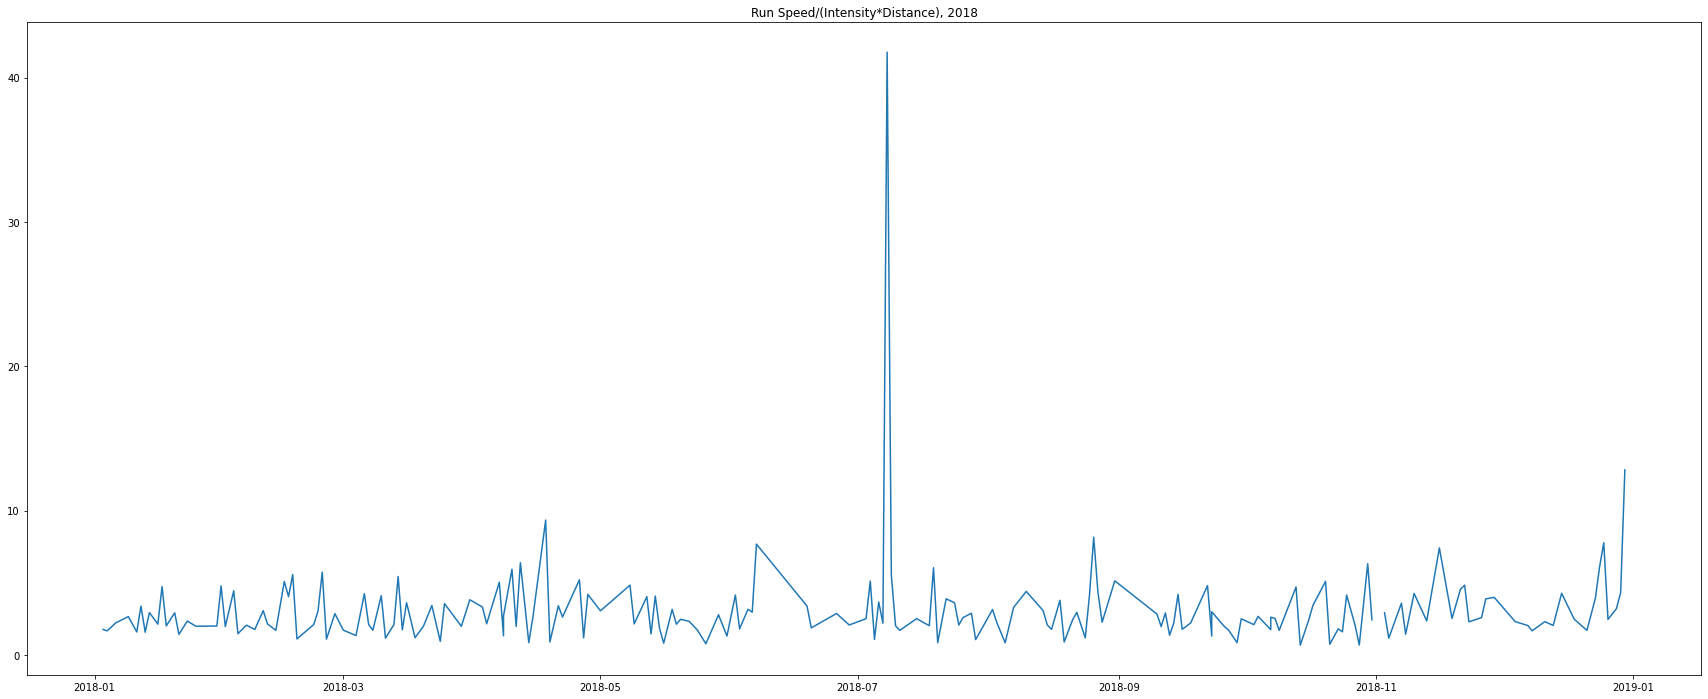

In [102]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['GAP_ft_s']/(run_2018['intensity']*run_2018['distance']))
plt.title('Run Speed/(Intensity*Distance), 2018')

Text(0.5, 1.0, 'Run Speed*Intensity*Distance, 2019')

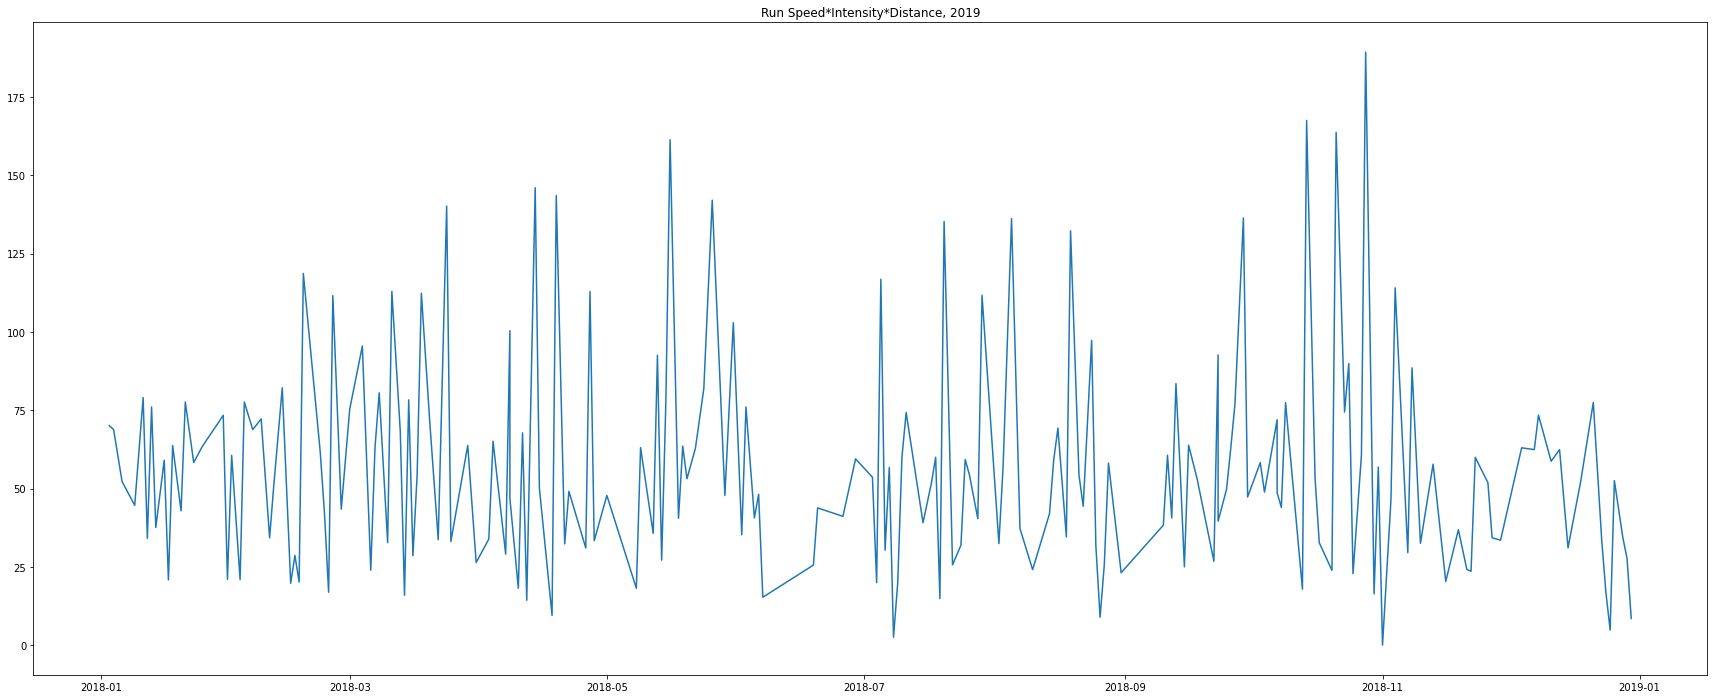

In [103]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['GAP_ft_s']*run_2018['distance']*run_2018['intensity'])
plt.title('Run Speed*Intensity*Distance, 2019')

In [104]:
run_2018['GAP_ft_s'].resample('W').mean()

date
2018-01-07    10.904920
2018-01-14    10.883352
2018-01-21    10.869678
2018-01-28    11.495823
2018-02-04    10.704139
2018-02-11    11.016748
2018-02-18    10.962020
2018-02-25    10.956132
2018-03-04    11.315447
2018-03-11    11.318752
2018-03-18    11.058697
2018-03-25    11.272695
2018-04-01    10.669713
2018-04-08    11.497526
2018-04-15    10.883960
2018-04-22    10.688753
2018-04-29    12.055454
2018-05-06    12.110146
2018-05-13    11.185810
2018-05-20    11.435481
2018-05-27    11.546333
2018-06-03    11.769825
2018-06-10    11.389961
2018-06-17          NaN
2018-06-24     9.204665
2018-07-01    11.013123
2018-07-08    10.847694
2018-07-15    10.687044
2018-07-22    10.407169
2018-07-29    11.107332
2018-08-05    10.764071
2018-08-12    10.702567
2018-08-19    11.199240
2018-08-26    10.757674
2018-09-02    10.997969
2018-09-09          NaN
2018-09-16    10.730557
2018-09-23    11.049287
2018-09-30    11.040032
2018-10-07    11.277607
2018-10-14    10.511972
2018-10-21 

In [105]:
run_2018['distance'].resample('W').sum()

date
2018-01-07    20.89
2018-01-14    30.14
2018-01-21    30.10
2018-01-28    12.81
2018-02-04    28.74
2018-02-11    24.81
2018-02-18    28.83
2018-02-25    25.49
2018-03-04    23.09
2018-03-11    32.96
2018-03-18    38.93
2018-03-25    29.50
2018-04-01    10.94
2018-04-08    29.55
2018-04-15    32.83
2018-04-22    27.12
2018-04-29    18.44
2018-05-06     5.01
2018-05-13    23.15
2018-05-20    44.93
2018-05-27    30.90
2018-06-03    27.35
2018-06-10    11.18
2018-06-17     0.00
2018-06-24     8.96
2018-07-01    10.40
2018-07-08    31.13
2018-07-15    21.97
2018-07-22    33.33
2018-07-29    32.59
2018-08-05    25.03
2018-08-12     7.24
2018-08-19    36.99
2018-08-26    26.29
2018-09-02    12.08
2018-09-09     0.00
2018-09-16    40.53
2018-09-23    23.40
2018-09-30    40.36
2018-10-07    24.87
2018-10-14    36.10
2018-10-21    30.54
2018-10-28    46.82
2018-11-04    35.61
2018-11-11    17.31
2018-11-18     8.11
2018-11-25    16.39
2018-12-02    12.27
2018-12-09    20.14
2018-12-16    1

Text(0.5, 1.0, 'Weekly Run Totals')

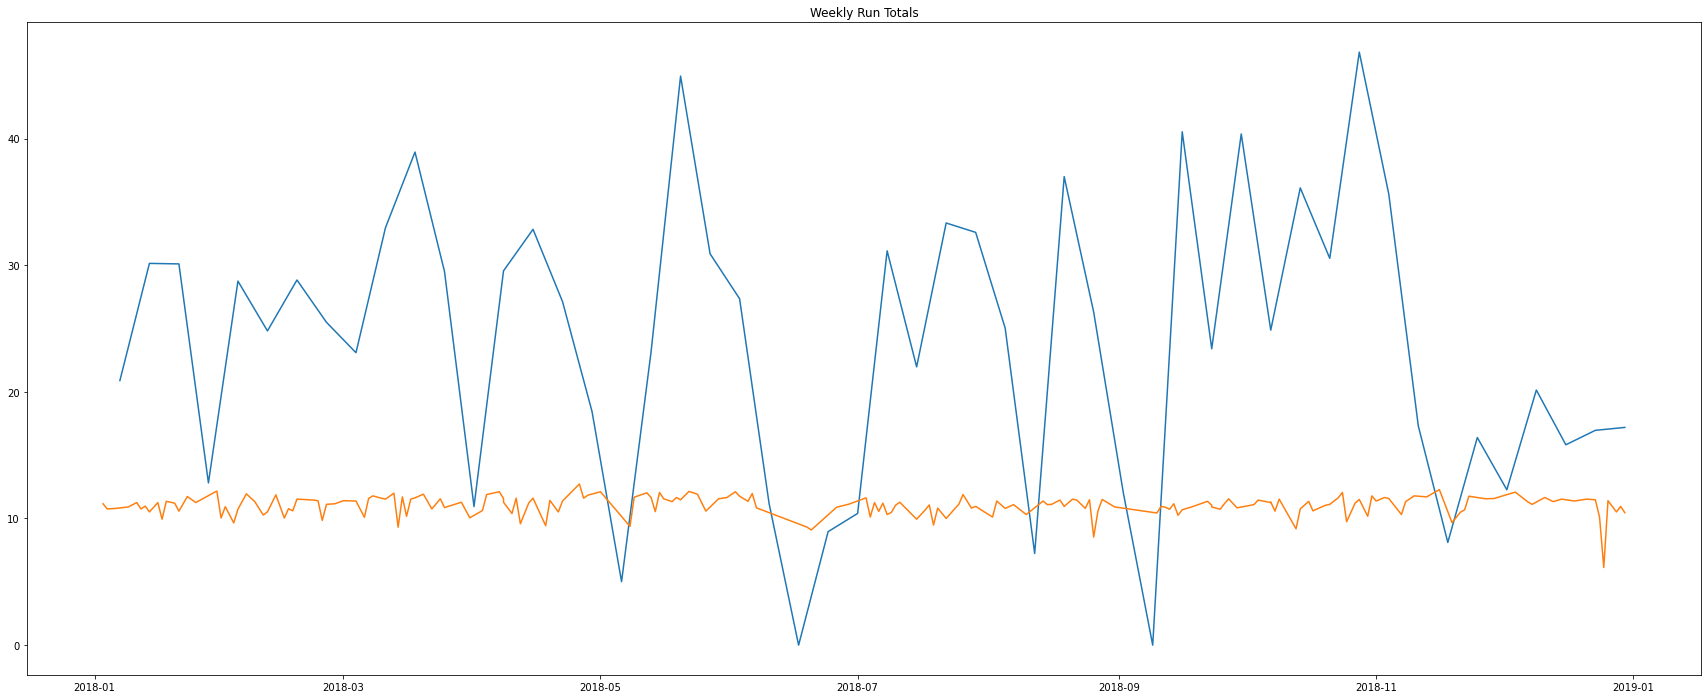

In [106]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['distance'].resample('W').sum())
plt.plot(run_2018['GAP_ft_s'])
plt.title('Weekly Run Totals')

Text(0.5, 1.0, 'Monthly Run Totals')

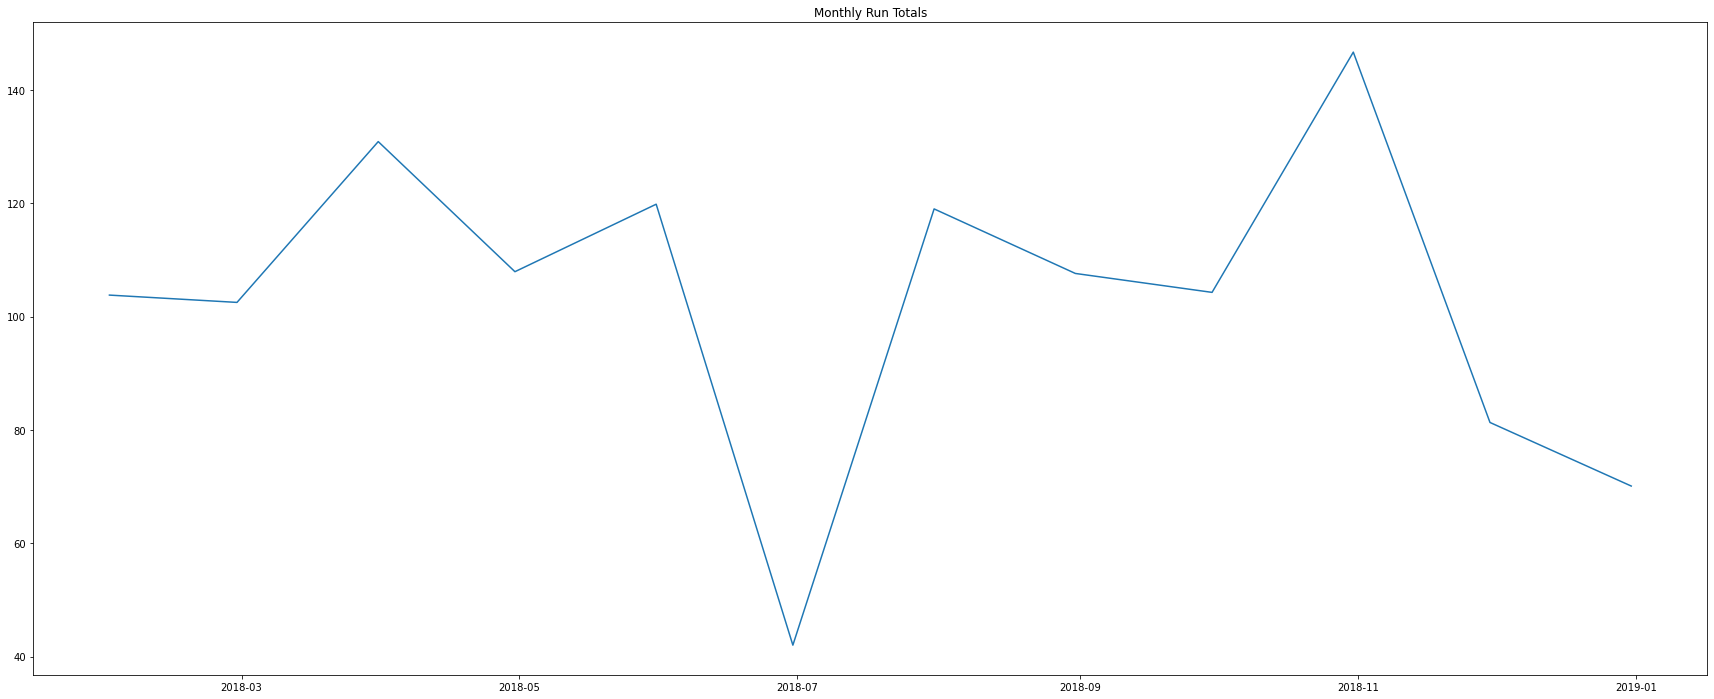

In [107]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['distance'].resample('M').sum())
plt.title('Monthly Run Totals')

Let's look a little deeper into 2018:


Text(0.5, 1.0, 'Run Speed/Intensity, 2018')

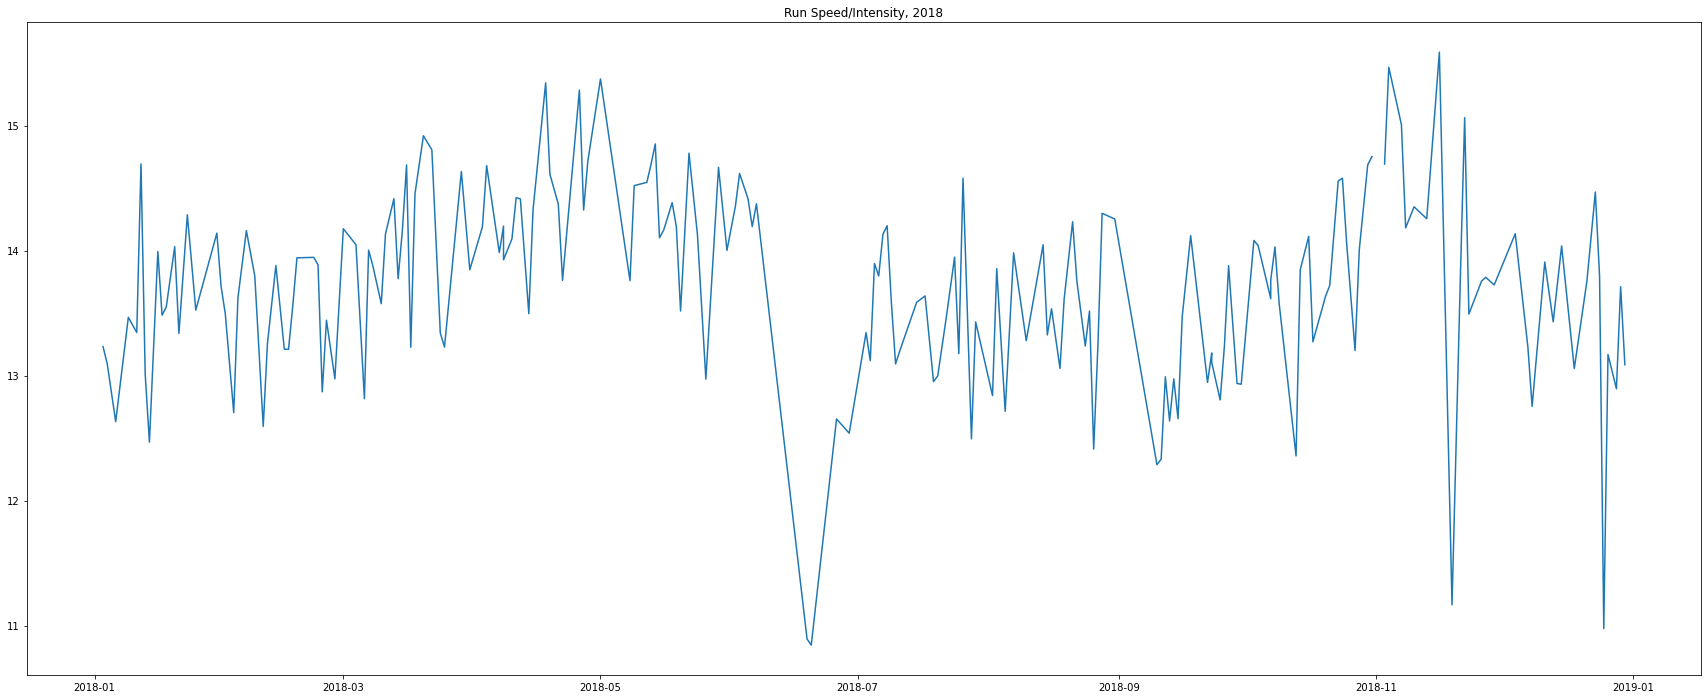

In [110]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['spd_ft_s']/(run_2018['intensity']))
plt.title('Run Speed/Intensity, 2018')

In [111]:
len(run_2018)

198

What do the moving averages look like?

In [124]:
speed = run_2019[['spd_ft_s']]

In [149]:
#calcuating 'Simple Moving Average' for 7 days:
run_2019['speed_SMA_7'] = run_2019['spd_ft_s'].rolling(window=7).mean()
#For 30 days:
run_2019['speed_SMA_30'] = run_2019['spd_ft_s'].rolling(window=30).mean()
#For 90 days:
run_2019['speed_SMA_90'] = run_2019['spd_ft_s'].rolling(window=90).mean()

In [138]:
#Calculating the exponential moving average:
run_2019['EMA'] = speed.iloc[:,0].ewm(span=40,adjust=False).mean()

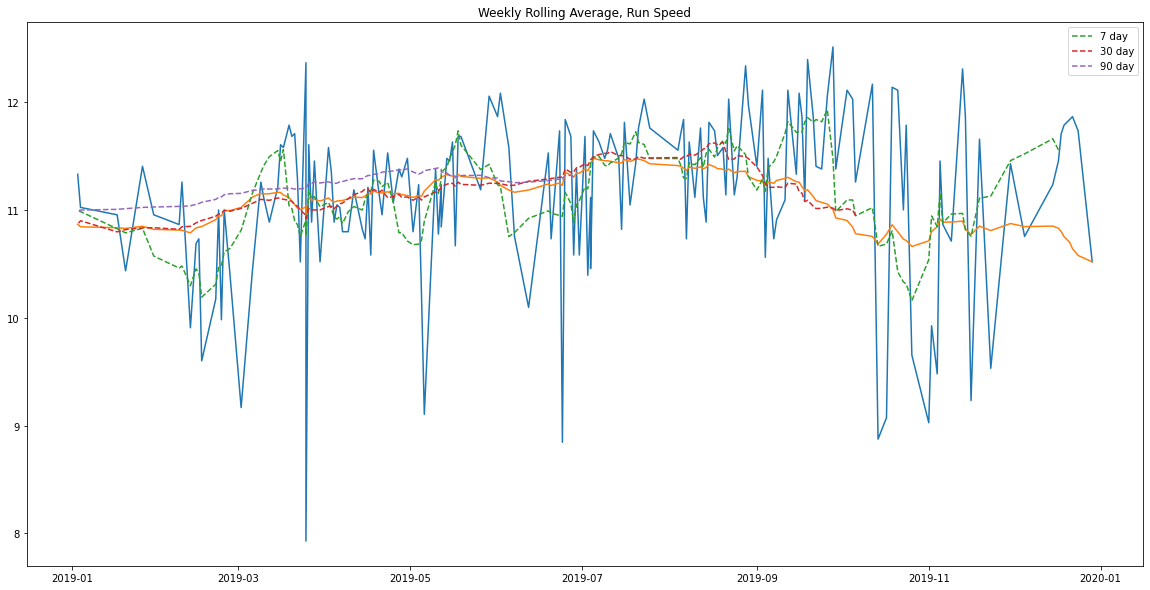

In [233]:
plt.figure(figsize = (20, 10))
plt.plot(speed)
plt.plot(run_2019['EMA'])
plt.plot(run_2019['speed_SMA_7'], '--', label = '7 day')
plt.plot(run_2019['speed_SMA_30'], '--', label = '30 day')
plt.plot(run_2019['speed_SMA_90'], '--', label = '90 day')
plt.title('Weekly Rolling Average, Run Speed')
plt.legend()

In [170]:
#calcuating 'Simple Moving Average' for 7 days:
run_2019['distance_SMA_7'] = run_2019['distance'].rolling(window=7).mean()
#For 30 days:
run_2019['distance_SMA_30'] = run_2019['distance'].rolling(window=30).mean()
#For 90 days:
run_2019['distance_SMA_90'] = run_2019['distance'].rolling(window=90).mean()
#Sums:
run_2019['distance_SMS_7'] = run_2019['distance'].rolling(window=7).sum()
#For 30 days:
run_2019['distance_SMS_30'] = run_2019['distance'].rolling(window=30).sum()
#For 90 days:
run_2019['distance_SMS_90'] = run_2019['distance'].rolling(window=90).sum()

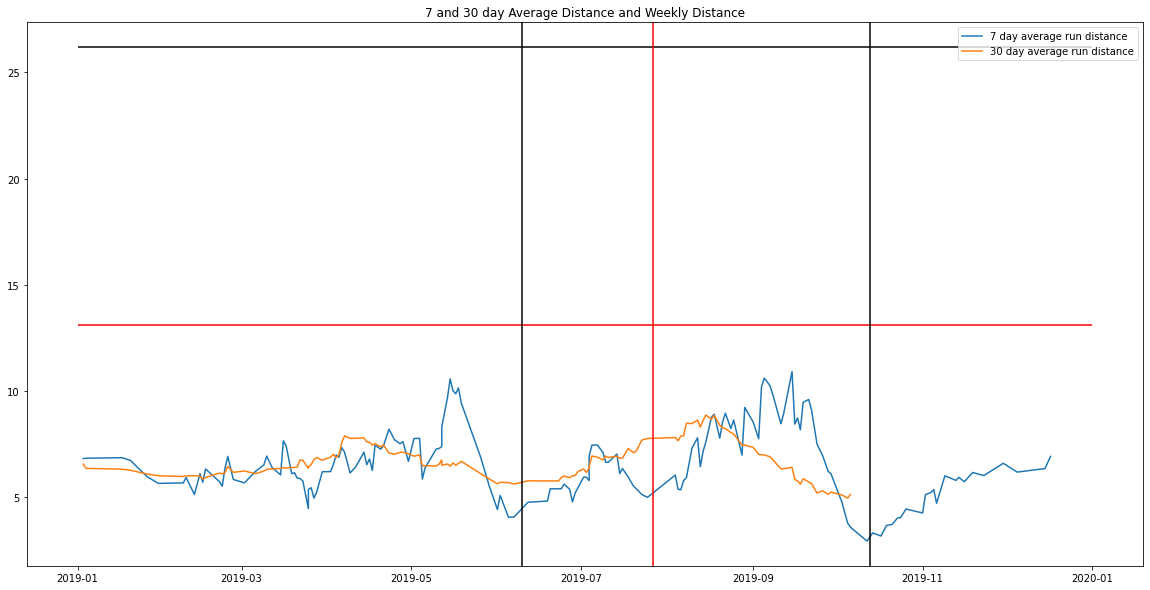

In [174]:
plt.figure(figsize = (20, 10))
plt.plot(run_2019['distance_SMA_7'], label = '7 day average run distance')
plt.plot(run_2019['distance_SMA_30'], label = '30 day average run distance')
plt.title('7 and 30 day Average Distance and Weekly Distance')
plt.axvline(dt.datetime(2019, 6, 10), color = 'black')
plt.axvline(dt.datetime(2019, 7, 27), color = 'red')
plt.axvline(dt.datetime(2019, 10, 13), color = 'black')
plt.hlines(26.2, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'black')
plt.hlines(13.1, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'red')
plt.legend()

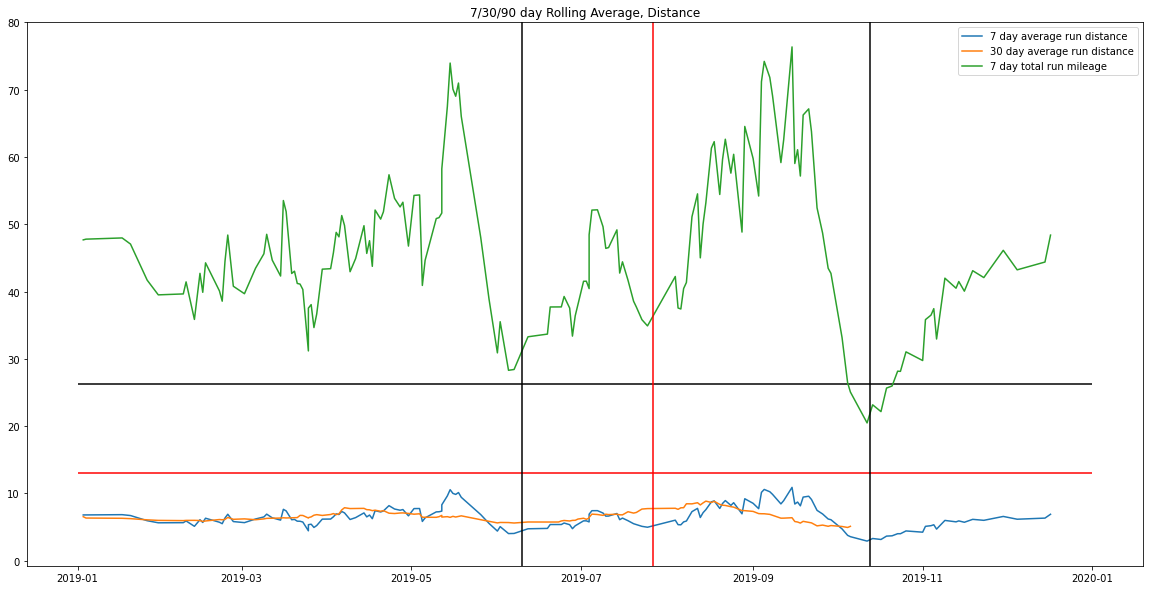

In [173]:
#Black lines are Marathon race dates and distances. Red lines are half marathon dates and distances.
plt.figure(figsize = (20, 10))
plt.plot(run_2019['distance_SMA_7'], label = '7 day average run distance')
plt.plot(run_2019['distance_SMA_30'], label = '30 day average run distance')
plt.plot(run_2019['distance_SMS_7'], label = '7 day total run mileage')
plt.title('7 and 30 day Average Distance and Weekly Distance')
plt.axvline(dt.datetime(2019, 6, 10), color = 'black')
plt.axvline(dt.datetime(2019, 7, 27), color = 'red')
plt.axvline(dt.datetime(2019, 10, 13), color = 'black')
plt.hlines(26.2, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'black')
plt.hlines(13.1, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'red')
plt.legend()

In [175]:
run_2019.columns

Index(['Unnamed: 0', 'index', 'activity_type', 'favorite', 'title', 'distance',
       'calories', 'time', 'avg_hr', 'max_hr', 'aerobic_te', 'avg_run_cadence',
       'max_run_cadence', 'avg_pace', 'best_pace', 'elev_gain', 'elev_loss',
       'avg_stride_length', 'avg_vertical_ratio', 'avg_vertical_oscillation',
       'avg_ground_contact_time', 'avg_gct_balance', 'avg_run_cadence_1',
       'max_run_cadence_1', 'normalized_powerâ_npâ', 'lr_balance',
       'training_stress_scoreâ', 'max_avg_power_20_min', 'avg_power',
       'max_power', 'grit', 'flow', 'total_strokes', 'avg__swolf',
       'avg_stroke_rate', 'total_reps', 'total_sets', 'climb_time',
       'bottom_time', 'min_temp', 'surface_interval', 'decompression',
       'best_lap_time', 'number_of_laps', 'max_temp', 'avg_resp', 'min_resp',
       'max_resp', 'athlete_id', 'filetype', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity',
       'EMA', 'SMA_7', 'speed_SMA_7', 'speed

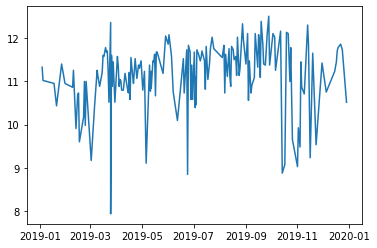

In [176]:
plt.plot(speed)

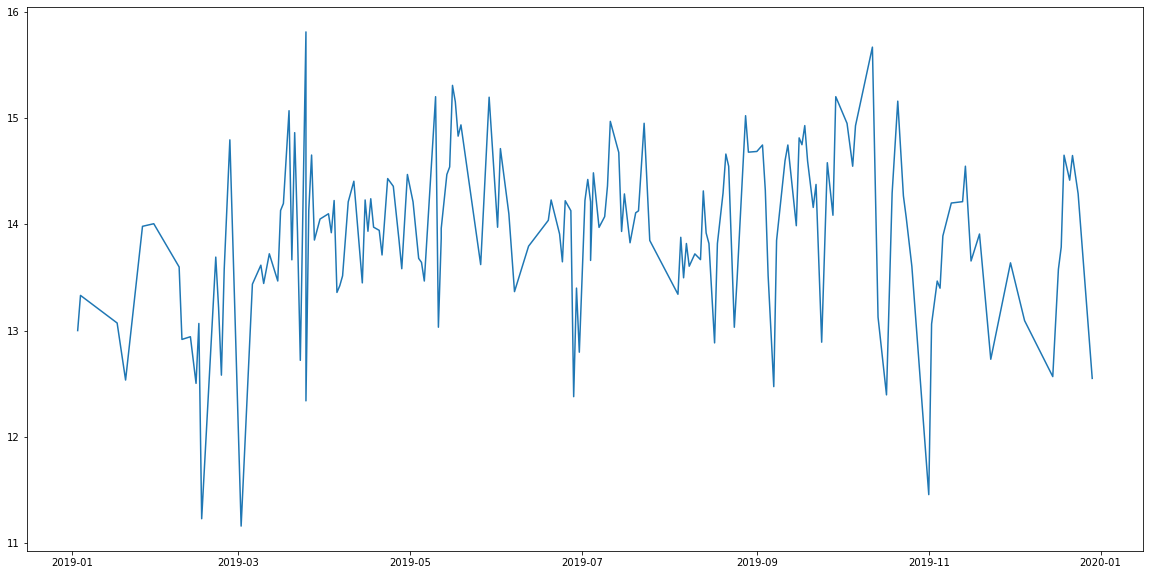

In [178]:
plt.figure(figsize = (20, 10))
plt.plot(run_2019['spd_ft_s']/(run_2019['intensity']))

In [244]:
#Let's use this as a starting point to derive a seasonal model for run pace.
#If we assume the pattern of the average speed to be a bell curve throughout the season, or training period, perhaps we can model it.
#Lets build a simple bell curve estimator first:
def bell_curve(x):
    σ = 35
    μ = 185
    return 2*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))

In [245]:
var = np.linspace(0, 365, 1000)

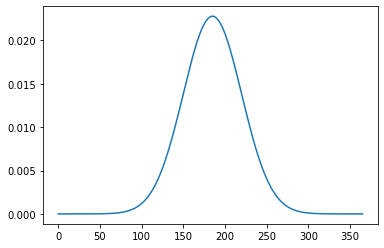

In [246]:
plt.plot(var, bell_curve(var))

In [191]:
#Ok moving on, can we add in variables to allow for local fluctuations?

In [280]:
def bell_curve2(x):
    σ = 35
    μ = 185
    return (1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(x+ np.cos(5*x))+ np.random.randn(1000)

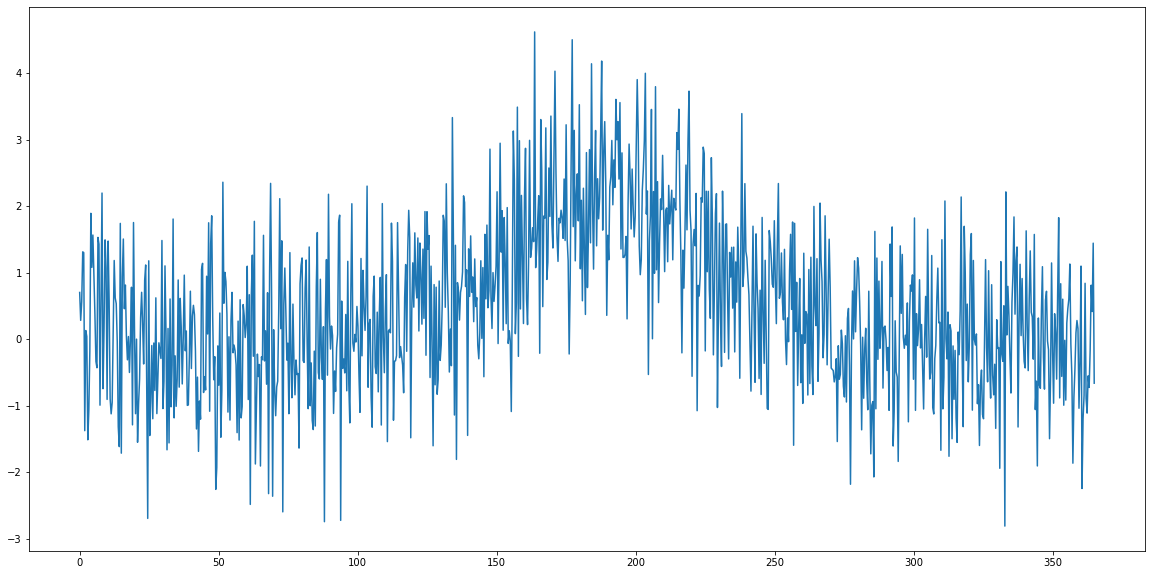

In [281]:
plt.figure(figsize = (20, 10))
plt.plot(var, bell_curve2(var))

In [282]:
obs = bell_curve2(var)
x = np.linspace(0, 365, 1000)

In [283]:
#Ok we can make a model with this, let's see how it does:

In [286]:
#build the model
with pm.Model() as guess:
    σ = pm.Uniform('σ', lower = 0, upper = 100)
    μ = pm.Uniform('μ', lower = 20, upper = 365)
    s = pm.Uniform('s', lower = 0, upper = 100)
    a = pm.Uniform('a', lower = 0, upper = 10)
    line = (1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(x+ np.cos(a*x))
    y = pm.Normal('y', mu = line, sd = s, observed = bell_curve2(x))
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, s, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [255]:
#import arviz as az

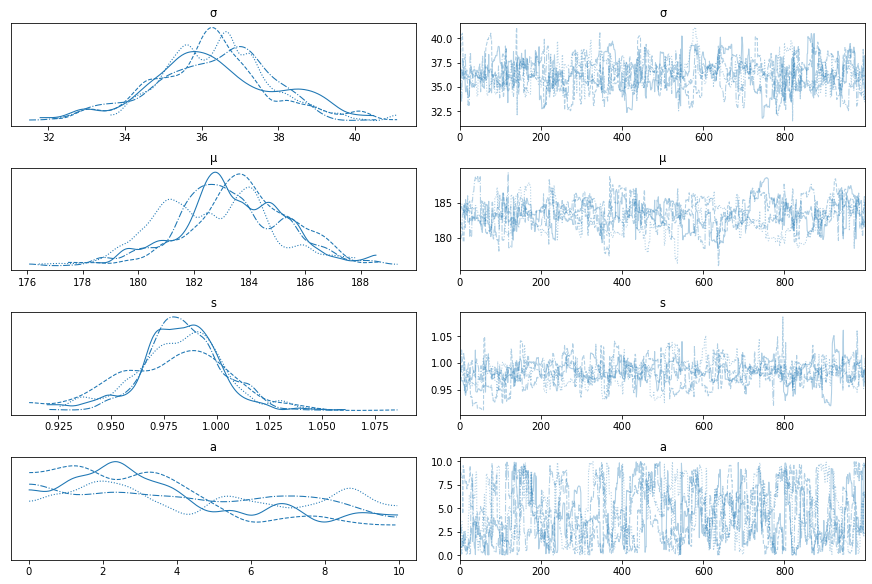

In [287]:
az.plot_trace(trace);